In [29]:
from salad.serialize import read
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table
import matplotlib.pyplot as plt

In [287]:
fakes = read("../search/new/DEEP/20190403/A0c/detector_1/fakes.pkl")
f = fakes[fakes['type'] == 'tno']
recovery = read("../search/new/DEEP/20190403/A0c/detector_1/snr_0.0/regular/clusters_recover.pkl")
catalog = read("../search/new/DEEP/20190403/A0c/detector_1/snr_0.0/regular/catalog.pkl")

In [106]:
results = []

for g in f.group_by("ORBITID").groups:
    idx = np.argsort(g['EXPNUM'])
    binary = len(g) != len(set(g['EXPNUM']))
    
    g = g[idx]
    orbit = g[0]['ORBITID']
    mag = g['MAG'].mean()
    c = SkyCoord(g['RA'] * u.deg, g['DEC'] * u.deg)
    c_0 = c[0]
    c_1 = c[-1]
    dt = (g[-1]['mjd_mid'] - g[0]['mjd_mid'])*u.day
    v = (c_1.separation(c_0) / dt).to(u.deg/u.day)
    phi = np.arctan2(c_1.dec - c_0.dec, c_1.ra - c_0.ra).to(u.deg)
    findable = False
    if v > 0.01 * u.deg/u.day and v < 0.03 * u.deg/u.day:
        if phi > 120 * u.deg and phi < 240 * u.deg:
            findable = True
            
    results.append(
        {
            "orbit": orbit,
            "v": v,
            "phi": phi,
            "findable": findable,
            "mag": mag,
            "found": len(recovery[orbit]['line']) > 0,
            "detected": recovery[orbit]['catalog']['fake'],
            "binary": binary,
        }
    )

results = astropy.table.Table(results)
results

orbit,v,phi,findable,mag,found,detected,binary
,deg / d,deg,,,,,
int64,float64,float64,bool,float64,bool,int64,bool
2405372,0.019558461629477754,168.39825700754162,True,24.573885428055313,False,70,False
2732908,0.012082481222041624,161.52027795964636,True,25.68617649738313,False,0,False
3881210,0.009545628956146747,161.1472486254834,False,26.306819324841076,False,40,False
3898678,0.014735776461058392,162.3771570720673,True,26.47601778348476,False,7,False
4279478,0.012096529156942875,155.47319226296221,True,24.78000547555636,True,57,False
5182786,0.00814373039496204,154.64506986598138,False,26.158283666804156,False,22,False
5485151,0.0006330107597850406,160.07987686781578,False,24.156122049911747,False,7,False
5962014,0.013612382654722257,163.04163601016464,True,24.547227600193064,True,68,False


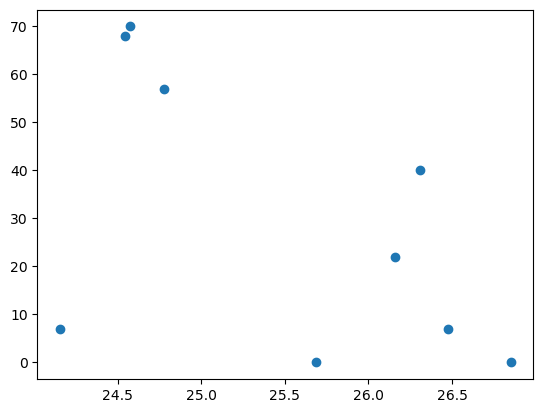

In [39]:
plt.scatter(results['mag'], results['detected'])
plt.show()

In [ ]:
# I need to consider the number of times I expect to observe an object as well
# say I want to observe it 20 times, then I can have no more than 0.3 = x/(20 + x); x = 20*0.3/0.7
# i.e. 8 noise detections
# this implies a contamination rate of 8/104 = 0.077
# the required dx for this is 0.937 and the minimum vote is 16.16412996463396

In [288]:
f = fakes[fakes['type'] == 'tno']

c_fake = SkyCoord(f['RA']*u.deg, f['DEC']*u.deg)
t1 = astropy.table.Table(data=[c_fake.ra, c_fake.dec, f['ORBITID'], f['EXPNUM']], names=['ra', 'dec', 'orbit', 'expnum'])
match_threshold_points = 1/3600

matches = {orbit : {"points": {}, "line": {}, "catalog": 0, "info": {}} for orbit in set(f['ORBITID'])}

x = catalog.X(columns=['ra', 'dec', 'time', 'exposures', 'significance'])
c_catalog = SkyCoord(x[:, 0]*u.deg, x[:, 1]*u.deg)
t_catalog = astropy.table.Table(
    data=[c_catalog.ra, c_catalog.dec, x[:, 2], x[:, 3], x[:, 4]], 
    names=['ra', 'dec', 'time', 'expnum', 'significance'],
)
for g in astropy.table.join(t1, t_catalog, keys=['expnum']).group_by(["orbit"]).groups:
    sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
    mask = sep.value < match_threshold_points
    n_matches = mask.sum()
    o = int(g[0]['orbit'])
    matches[o]['catalog'] = {
        "fake": n_matches, # number of matches to fakes
        "total": len(fakes[fakes['ORBITID'] == o]), # number of injected fakes
        "coords": SkyCoord(g['ra_2'], g['dec_2'])[mask],
        'time': g['time'][mask],
        "snr": g['significance'][mask],
    }

In [63]:
sep.value < 1/3600

array([False, False, False, ..., False, False, False])

In [57]:
_c = catalog.X()[sep.to(u.deg).value < 1/3600]

In [82]:
catalog.X(columns=['significance'])

array([[2.46109083e-01],
       [4.15651512e+00],
       [1.25304058e-01],
       ...,
       [1.19777657e-02],
       [1.17283454e-02],
       [2.70594074e-03]])

In [266]:
np.abs(_f['mjd_mid'] - t).min()

0.0005993613813188858

In [263]:
t 

58577.28477227222

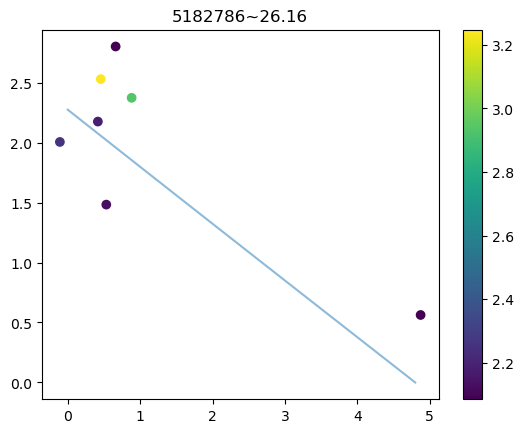

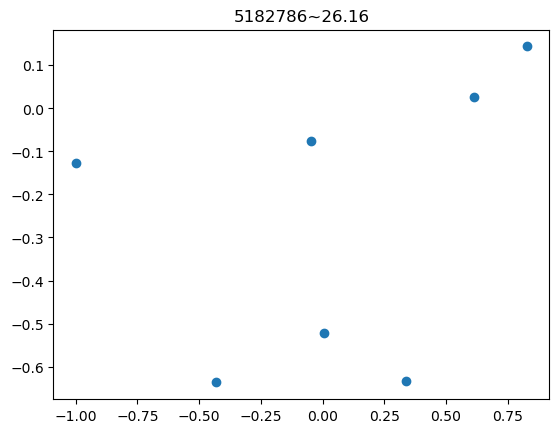

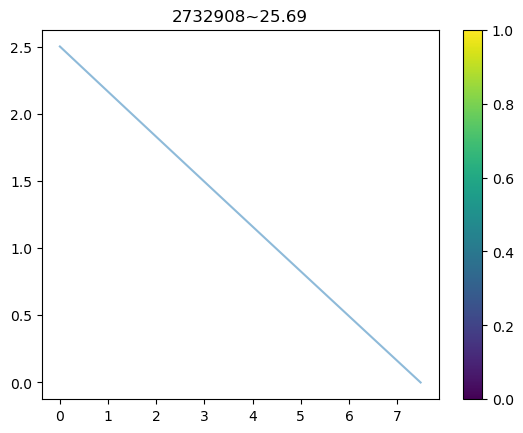

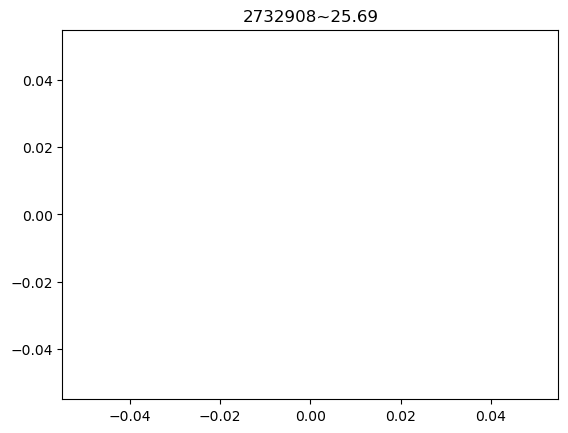

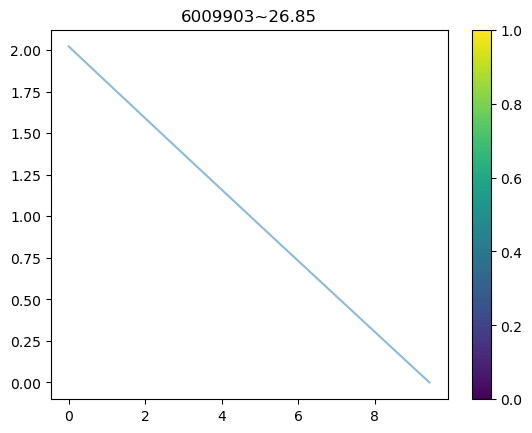

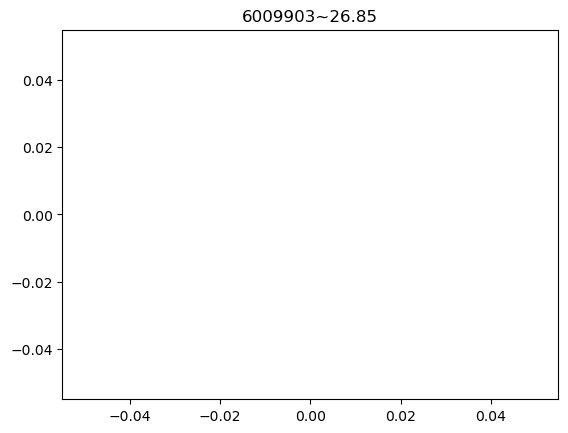

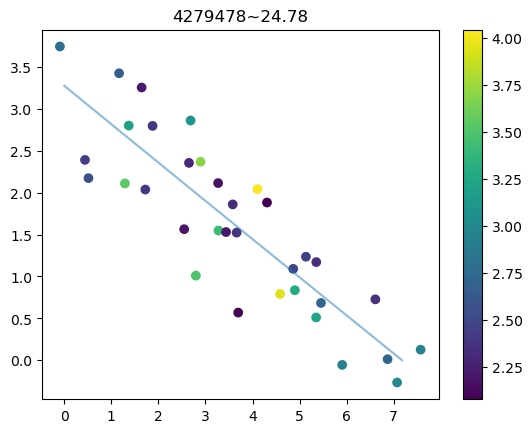

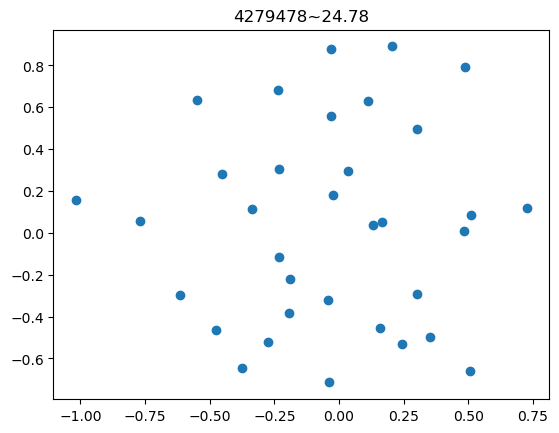

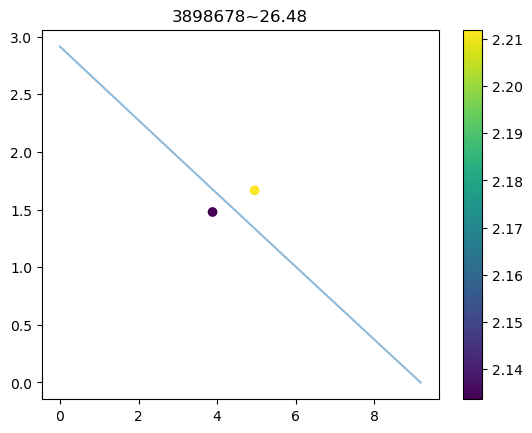

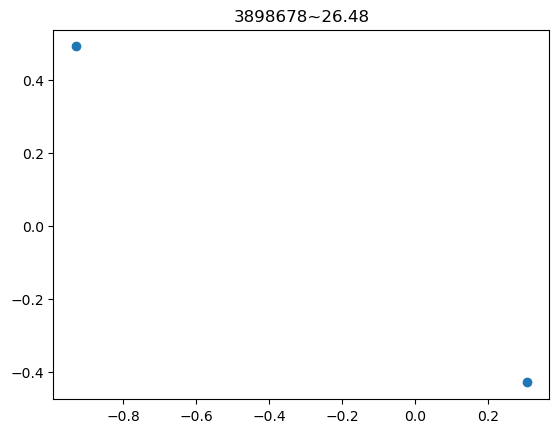

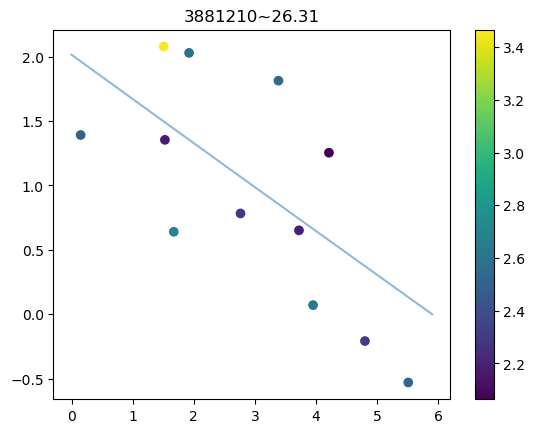

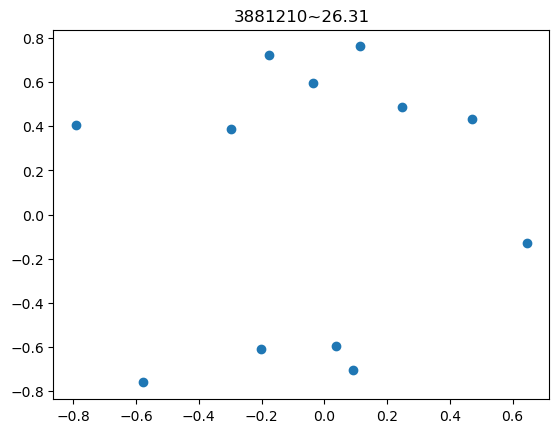

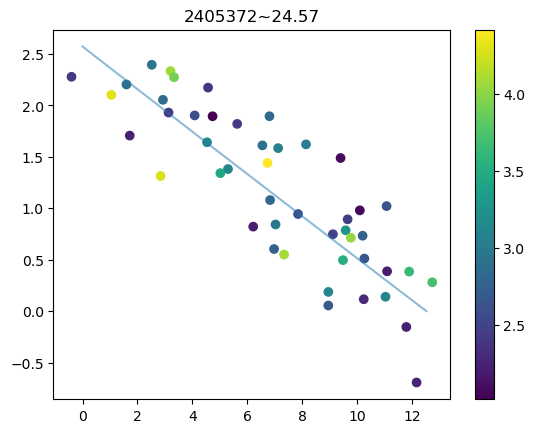

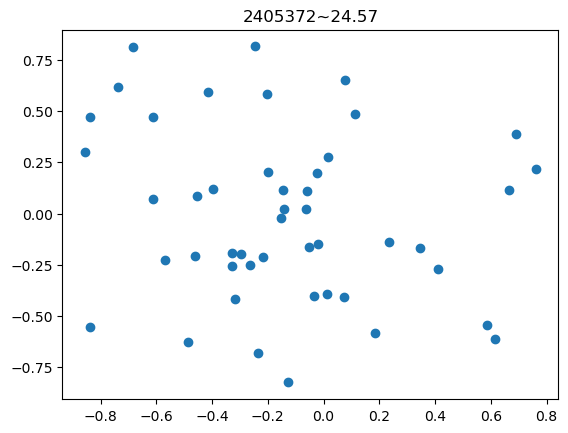

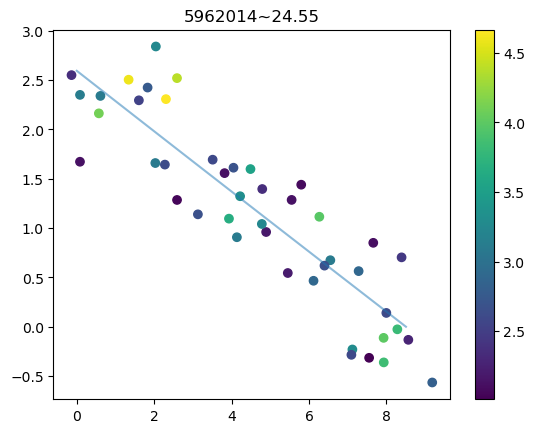

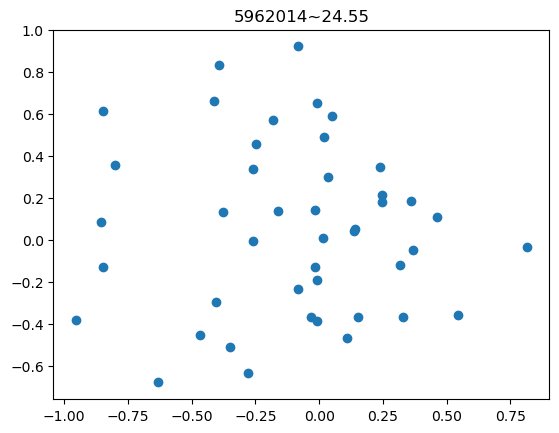

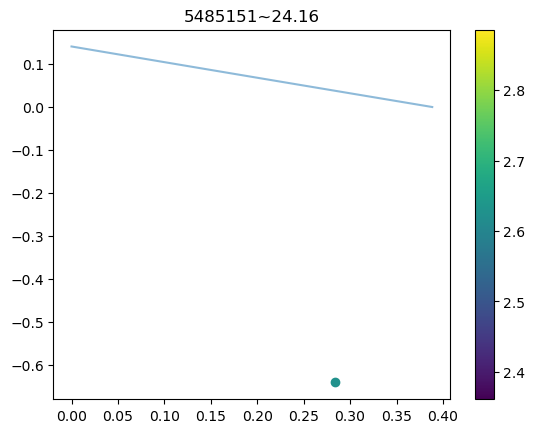

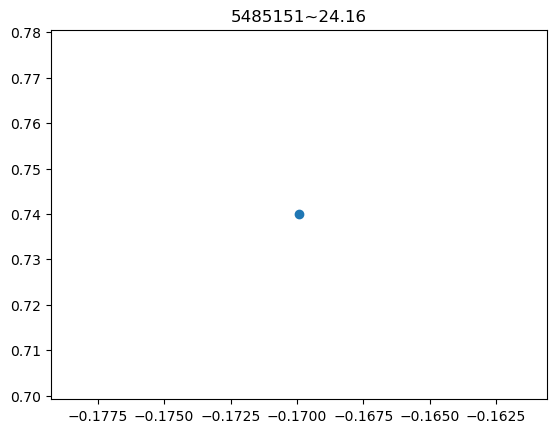

In [289]:
# _co = SkyCoord(_c[:, 0]*u.deg, _c[:, 1]*u.deg)

for k in matches:
    _f = f[f['ORBITID'] == k]
    mag = _f['MAG'].mean()
    _cf = SkyCoord(_f['RA']*u.deg, _f['DEC']*u.deg)
    _c = matches[k]['catalog']['coords']
    _ct = matches[k]['catalog']['time']
    
    dra = []
    ddec = []
    for c, t in zip(_c, _ct):
        f_mask = np.abs(_f['mjd_mid'] - t).argmin()
#         c_mask = _ct == t
#         assert(f_mask.sum() == 1)
        dra.append((_cf[f_mask].ra - c.ra).to(u.arcsec).value)
        ddec.append((_cf[f_mask].dec - c.dec).to(u.arcsec).value)
        
    s = matches[k]['catalog']['snr']
    o_ra = _cf.ra.min()
    o_dec = _cf.dec.min()
    plt.scatter((_c.ra - o_ra).to(u.arcsec), (_c.dec - o_dec).to(u.arcsec), c=s)
    plt.plot((_cf.ra - o_ra).to(u.arcsec), (_cf.dec - o_dec).to(u.arcsec), alpha=0.5)
    plt.title(f"{k}~{mag:0.2f}")
    plt.colorbar()
    plt.show()
    plt.scatter(dra, ddec)
    plt.title(f"{k}~{mag:0.2f}")    
    plt.show()

In [97]:
from salad.analysis import plot as analysis_plot

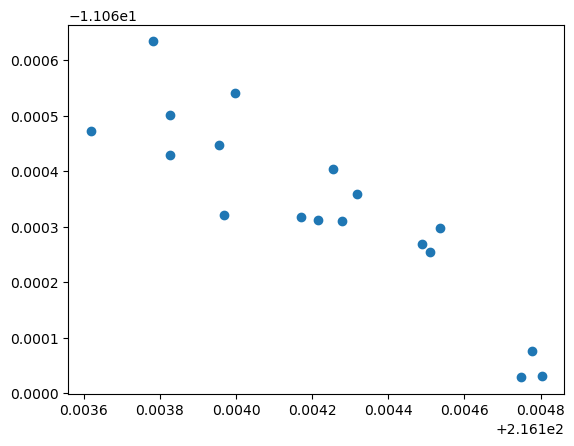

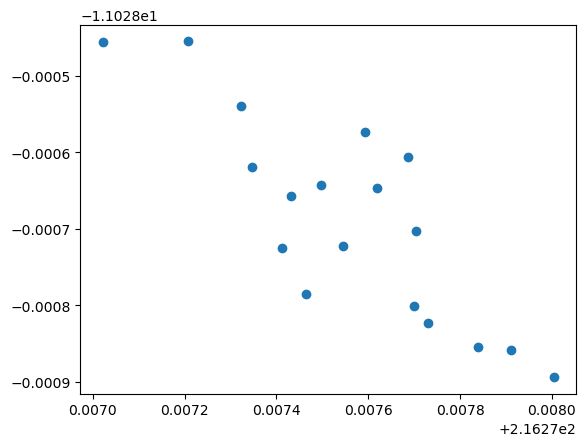

In [104]:
clusters = read("../search/new/DEEP/20190403/A0c/detector_1/snr_0.0/regular/clusters.pkl")
analysis_plot.plot_cluster(clusters[10])
plt.show()
analysis_plot.plot_cluster(clusters[17])
plt.show()

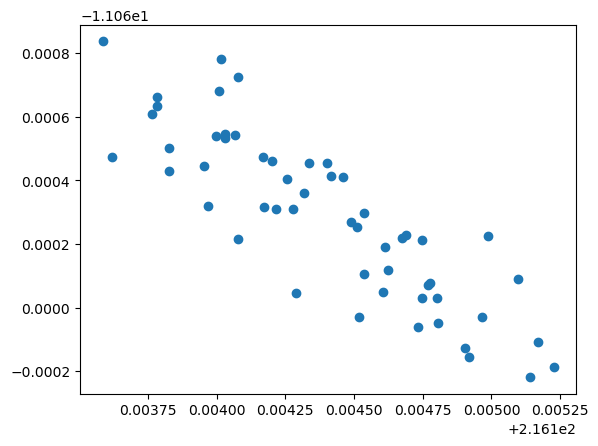

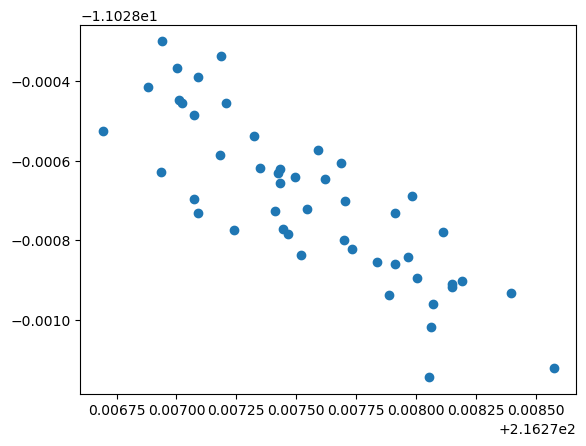

In [105]:
clusters = read("../search/new/DEEP/20190403/A0c/detector_1/snr_0.0/regular/gathered_1.pkl")
analysis_plot.plot_cluster(clusters[10])
plt.show()
analysis_plot.plot_cluster(clusters[17])
plt.show()

In [110]:
matches[3881210]['catalog']['snr']

1.6727478504180908
2.4303677082061768
0.7117770910263062
2.064753532409668
0.4146485924720764
2.5871670246124268
2.221374034881592
0.9768174290657043
2.1690309047698975
1.4802186489105225
0.95399409532547


In [114]:
matches[3881210]

{'points': {},
 'line': {},
 'catalog': {'fake': 40,
  'total': 104,
  'coords': <SkyCoord (ICRS): (ra, dec) in deg
      [(216.02127455, -11.05185596), (216.02106626, -11.05215735),
       (216.02070909, -11.05178071), (216.02086953, -11.05206807),
       (216.02085522, -11.05192259), (216.02063384, -11.05199063),
       (216.02056978, -11.05182942), (216.02043678, -11.05182076),
       (216.02070596, -11.05166214), (216.02042151, -11.05182149),
       (216.02044205, -11.0516283 ), (216.02070348, -11.0518992 ),
       (216.02051134, -11.05165765), (216.0205157 , -11.05202226),
       (216.02028917, -11.05180086), (216.02058296, -11.05165184),
       (216.02043097, -11.05148743), (216.02047661, -11.05150691),
       (216.02043889, -11.0519201 ), (216.02017087, -11.05170633),
       (216.02030413, -11.05179305), (216.02044708, -11.05173099),
       (216.02012628, -11.05161334), (216.02037825, -11.05158002),
       (216.0200706 , -11.05144703), (216.02000105, -11.05183259),
       (216.0

In [121]:
from salad.project import project
from salad.directions import SearchDirections
from salad.hough import Hough

In [241]:
mt = matches[3881210]['catalog']['time']

In [283]:
m = matches[3881210]['catalog']['coords']
m, len(m)

(<SkyCoord (ICRS): (ra, dec) in deg
     [(216.02127455, -11.05185596), (216.02106626, -11.05215735),
      (216.02070909, -11.05178071), (216.02086953, -11.05206807),
      (216.02085522, -11.05192259), (216.02063384, -11.05199063),
      (216.02056978, -11.05182942), (216.02043678, -11.05182076),
      (216.02070596, -11.05166214), (216.02042151, -11.05182149),
      (216.02044205, -11.0516283 ), (216.02070348, -11.0518992 ),
      (216.02051134, -11.05165765), (216.0205157 , -11.05202226),
      (216.02028917, -11.05180086), (216.02058296, -11.05165184),
      (216.02043097, -11.05148743), (216.02047661, -11.05150691),
      (216.02043889, -11.0519201 ), (216.02017087, -11.05170633),
      (216.02030413, -11.05179305), (216.02044708, -11.05173099),
      (216.02012628, -11.05161334), (216.02037825, -11.05158002),
      (216.0200706 , -11.05144703), (216.02000105, -11.05183259),
      (216.02011658, -11.05174955), (216.0201968 , -11.05155392),
      (216.01995537, -11.05143321), (216

In [213]:
X = catalog.X(columns=["ra", "dec", "time", "exposures", "significance"])
dt = (X[:, 2].max() - X[:, 2].min())*u.day
dx = 0.93

directions = SearchDirections([0.009, 0.01]*u.deg/u.day, [158, 162]*u.deg, dx*u.arcsec, dt)
projection = project(X, directions, X[:, 2].min())
hough = Hough(projection, dx*u.arcsec, dx*u.arcsec)

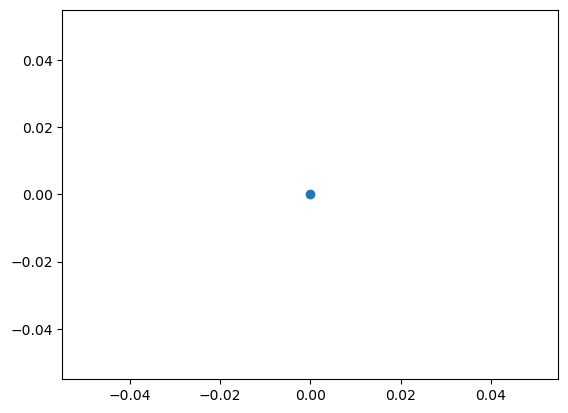

In [279]:
x = X[(
    (np.abs(X[:, 0] - m[3].ra.value) < 1e-6) &
    (np.abs(X[:, 1] - m[3].dec.value) < 1e-6)
)]

plt.scatter(
    x[:, 0]-x[:,0].min(),
    x[:, 1] - x[:, 1].min()
)
plt.show()

In [215]:
np.abs((projection.projected[0, :, 1] - m.dec[3].value)).min()

2.678778088238687e-09

In [284]:
mask = np.logical_and(
    np.logical_or.reduce([np.abs(X[:, 0] - r.value) < 1e-6 for r in m.ra]),
    np.logical_or.reduce([np.abs(X[:, 1] - r.value) < 1e-6 for r in m.dec]),
    np.logical_or.reduce([np.abs(X[:, 2] - r) < 1e-6 for r in mt]),
)
mask.sum()

40

In [247]:
projection.directions.b[0]

<Quantity [-0.00855178,  0.00303401] deg / d>

In [ ]:
line = Line(
    alpha=np.array(
        [
            (x * self.dx + self.min_x + self.dx/2), 
            (y * self.dy + self.min_y + self.dy/2)
        ]
    ) * self.sky_units,
    beta=self.projection.directions.b[b],
    offset=self.projection.reference_time
)


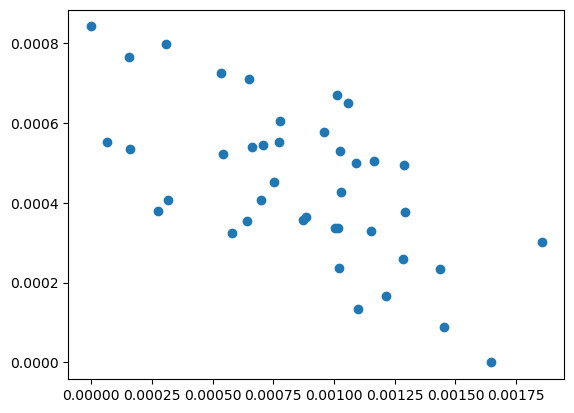

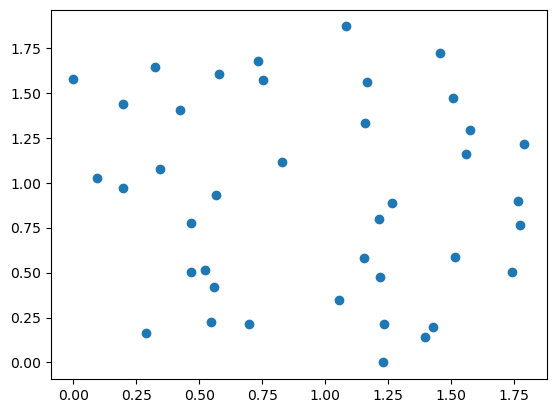

In [285]:
x = X[mask]

plt.scatter(
    x[:, 0]-x[:,0].min(),
    x[:, 1] - x[:, 1].min()
)
plt.show()

p = projection.projected[0, mask]
plt.scatter(
    (p[:, 0] - p[:, 0].min())*3600,
    (p[:, 1] - p[:, 1].min())*3600
)
plt.show()


In [286]:



for b in np.unique(hough.bins[0, mask], axis=0):
    print(
        hough.array[0, b[0], b[1]], 
        ((hough.bins[0, mask][:, 0] == b[0]) & (hough.bins[0, mask][:, 1] == b[1])).sum()
    )
    

5 2
7 7
9 9
8 3
14 8
12 10
5 1


In [210]:
hough.array[0,b[0], b[1]]

8

8
3
6
9
5
6
6
6
5
8
4
1
6
11
6
7
4
2
5
2
7
9
8
12
5
8


In [202]:
hough.argmax()

(0, 156, 471)